In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.signal as signal
import scipy as sc
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima.model import ARIMA

In [2]:
folder_path_X = "/network/lustre/iss02/aramis/projects/cracknetworks/X_couple/X_couple"
folder_path_Y = "/network/lustre/iss02/aramis/projects/cracknetworks/Y_folder/Y_folder"

In [3]:
X1 = np.load(folder_path_X + "/1_1000_cpl.npy")
Y1 = np.load(folder_path_Y + "/1_1000_coh.npy")

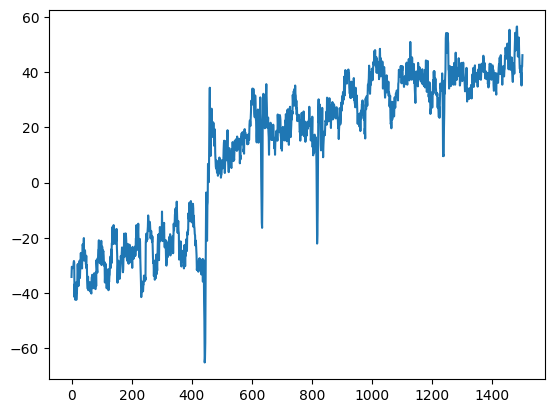

In [4]:
xa = X1[0, 0, :]
xb = X1[0, 1, :]
plt.plot(xb)
plt.show()

In [5]:
def adf_test(timeseries):
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)

In [6]:
adf_test(xa)

Results of Dickey-Fuller Test:
Test Statistic                   -5.302765
p-value                           0.000005
#Lags Used                       22.000000
Number of Observations Used    1478.000000
Critical Value (1%)              -3.434782
Critical Value (5%)              -2.863497
Critical Value (10%)             -2.567812
dtype: float64


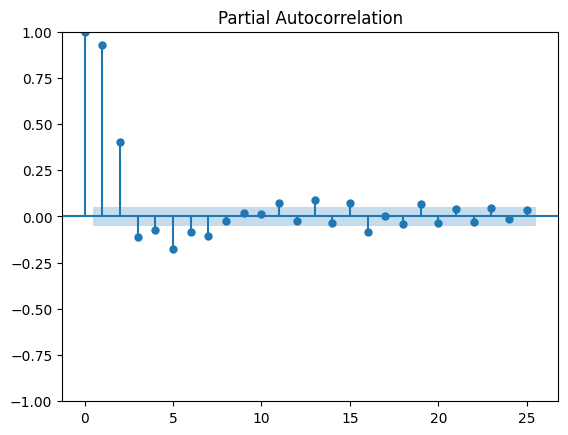

In [9]:
pacf = plot_pacf(xa, lags=25)

## Smoothing

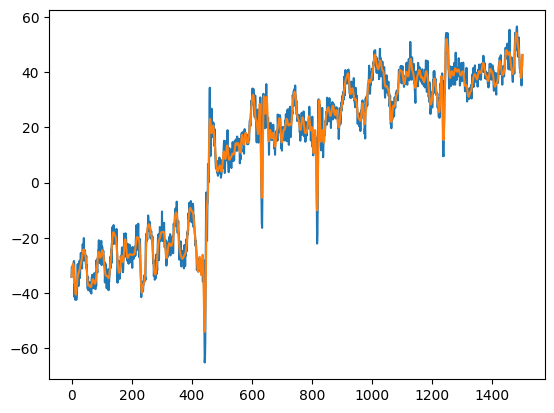

In [13]:
low_pass = signal.butter(10, 0.2, "low")
low_pass_filter = signal.filtfilt(*low_pass, xb)
plt.plot(xb)
plt.plot(low_pass_filter)
plt.show()

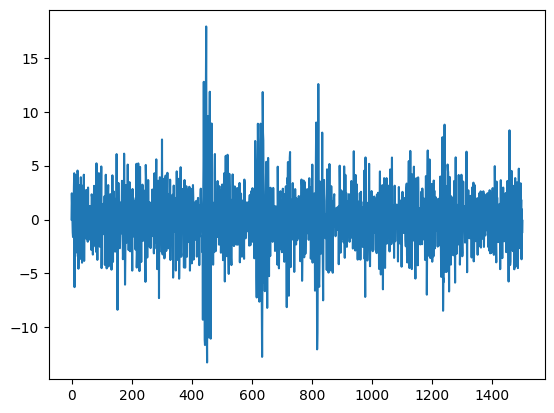

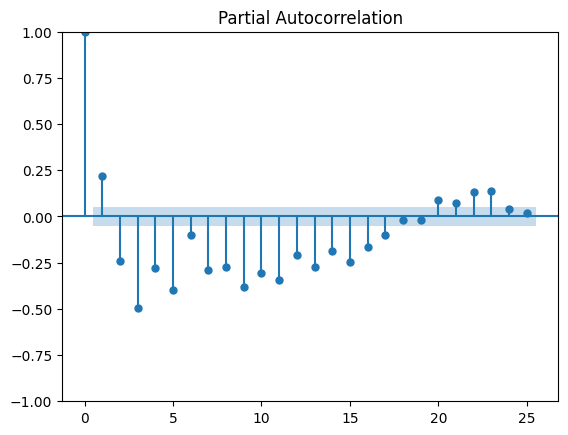

In [14]:
residual_low_pass = xb - low_pass_filter
plt.plot(residual_low_pass)
plt.show()

pacf = plot_pacf(residual_low_pass, lags=25)

## Trend

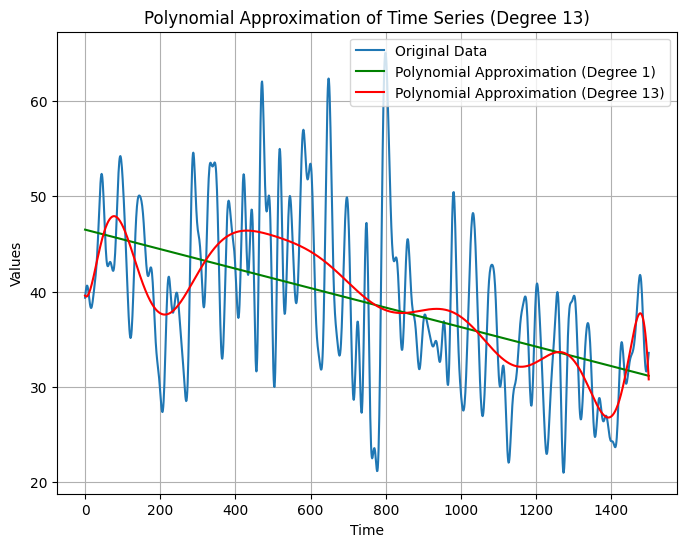

In [103]:
# Replace this with your own time series data
time = np.arange(np.shape(xa)[0])
values = low_pass_filter

# Fitting a polynomial of degree 1 and 13
linear_coefficients = np.polyfit(time, values, 1)
lin_function = np.poly1d(linear_coefficients)
predicted_lin_values = lin_function(time)

coefficients = np.polyfit(time, values, 13)
poly_function = np.poly1d(coefficients)
predicted_values = poly_function(time)

# Plotting the original time series and the polynomial approximation
plt.figure(figsize=(8, 6))
plt.plot(time, values, label='Original Data')
plt.plot(time, predicted_lin_values, color='green', label='Polynomial Approximation (Degree 1)')
plt.plot(time, predicted_values, color='red', label='Polynomial Approximation (Degree 13)')
plt.xlabel('Time')
plt.ylabel('Values')
plt.title('Polynomial Approximation of Time Series (Degree 13)')
plt.legend()
plt.grid(True)
plt.show()

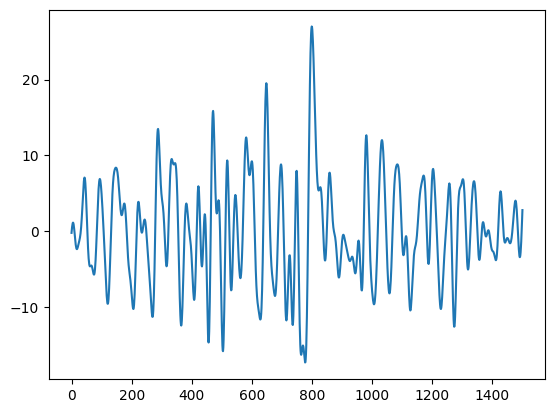

In [104]:
detrended_signal = values - predicted_values
plt.plot(time, detrended_signal)

# Seasonality

In [105]:
def get_largest_local_max(
    signal1D: np.ndarray, n_largest: int = 3, order: int = 1
) -> [np.ndarray, np.ndarray]:
    """Return the largest local max and the associated index in a tuple.

    This function uses `order` points on each side to use for the comparison.
    """
    all_local_max_indexes = signal.argrelmax(signal1D, order=order)[0]
    all_local_max = np.take(signal1D, all_local_max_indexes)
    largest_local_max_indexes = all_local_max_indexes[all_local_max.argsort()[::-1]][
        :n_largest
    ]

    return (
        np.take(signal1D, largest_local_max_indexes),
        largest_local_max_indexes,
    )

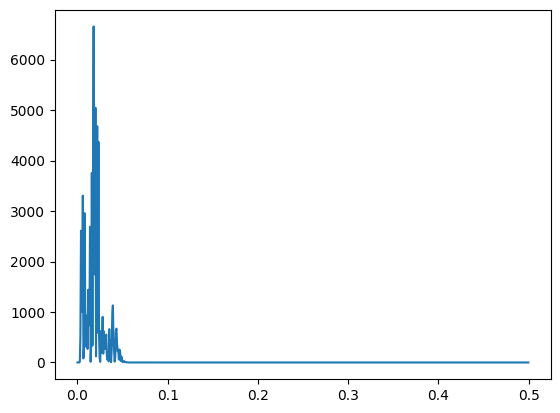

[6.65695210e+03 5.04687008e+03 4.67964091e+03 4.37219560e+03
 3.75491508e+03 3.30566739e+03 2.95849983e+03 2.68846594e+03
 2.61111419e+03 1.44172696e+03 1.13128437e+03 9.30905721e+02
 9.03995079e+02 6.70175732e+02 6.61074985e+02 6.21975189e+02
 6.18227855e+02 5.51255120e+02 4.35792260e+02 2.54477267e+02
 2.51821572e+02 1.18795997e+02 9.55563320e+01 2.66312135e+01
 1.01719999e+00 9.10248792e-01 3.72710131e-01 2.38291803e-01
 2.04427503e-01 1.58998773e-01 1.32394778e-01 1.19528926e-01]
[ 27  30  33  35  24   9  12  21   6  18  59  16  42  65  53  39  44  48
  55  70  68  73  51  78  86  84  90  92  95 100 104 107]


In [107]:
time_array = np.arange(np.shape(detrended_signal)[0])
signal_eeg = detrended_signal

frequencies, psd = signal.periodogram(signal_eeg)

plt.plot(frequencies, psd)
plt.show()

largest_local_max, largest_local_max_indexes = get_largest_local_max(psd, n_largest=1000)

print(largest_local_max)
print(largest_local_max_indexes)


In [78]:
X.shape

(52535,)

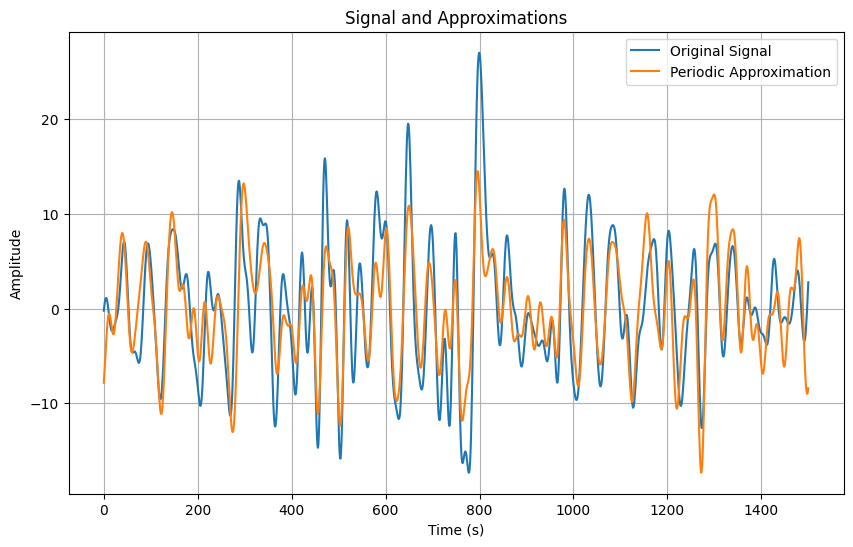

In [108]:
freqs = largest_local_max_indexes / len(signal_eeg)

y = signal_eeg
li = [np.cos(2*np.pi*freqs[i]*time_array) for i in range(len(freqs))] + [np.sin(2*np.pi*freqs[i]*time_array) for i in range(len(freqs))] + [np.ones_like(time_array)]
X = np.vstack(li).T


beta, *_ = np.linalg.lstsq(X, y, rcond=-1)

approx_season = X @ beta


plt.figure(figsize=(10, 6))
plt.plot(time_array, signal_eeg, label='Original Signal')
plt.plot(time_array, approx_season, label='Periodic Approximation')
plt.title('Signal and Approximations')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)

plt.show()

# AutoRegressive Model

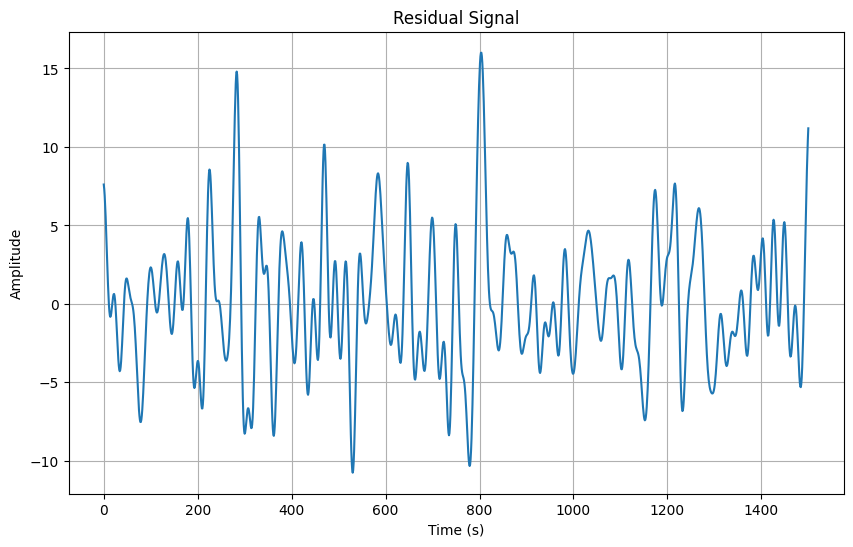

In [109]:
residual_signal = signal_eeg - approx_season

plt.figure(figsize=(10, 6))
plt.plot(time_array, residual_signal)
plt.title('Residual Signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()

In [110]:
n = len(xa)
ntrain = 300
ntest = n - ntrain
lag = 20
ar_model = AutoReg(detrended_signal[:ntrain], lags = lag)
res = ar_model.fit()
print(res.summary())

                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                  300
Model:                    AutoReg(20)   Log Likelihood                1538.662
Method:               Conditional MLE   S.D. of innovations              0.001
Date:                Thu, 16 May 2024   AIC                          -3033.324
Time:                        14:01:15   BIC                          -2953.359
Sample:                            20   HQIC                         -3001.250
                                  300                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.387e-11   6.26e-05  -2.21e-07      1.000      -0.000       0.000
y.L1          12.4539   1.81e+05    6.9e-05      1.000   -3.54e+05    3.54e+05
y.L2         -70.1234    2.3e+06  -3.05e-05      1.0

In [111]:
params = res.params
pvalues = res.pvalues
params[pvalues > 0.005] = 0

In [112]:
def predict(params, initial_condition, lag, n):
    signal = np.zeros(n)
    signal[:lag] = initial_condition
    for i in range(lag, n):
        signal[i] = np.sum(params * signal[i-lag:i])
    return signal

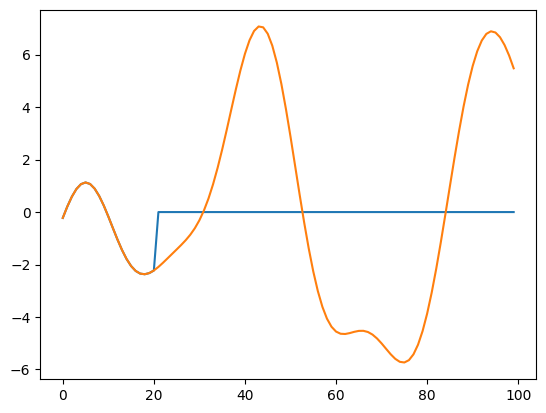

In [114]:
predicted_signal = predict(params, detrended_signal[:len(params)], len(params), 100)
plt.plot(predicted_signal)
plt.plot(detrended_signal[:100])

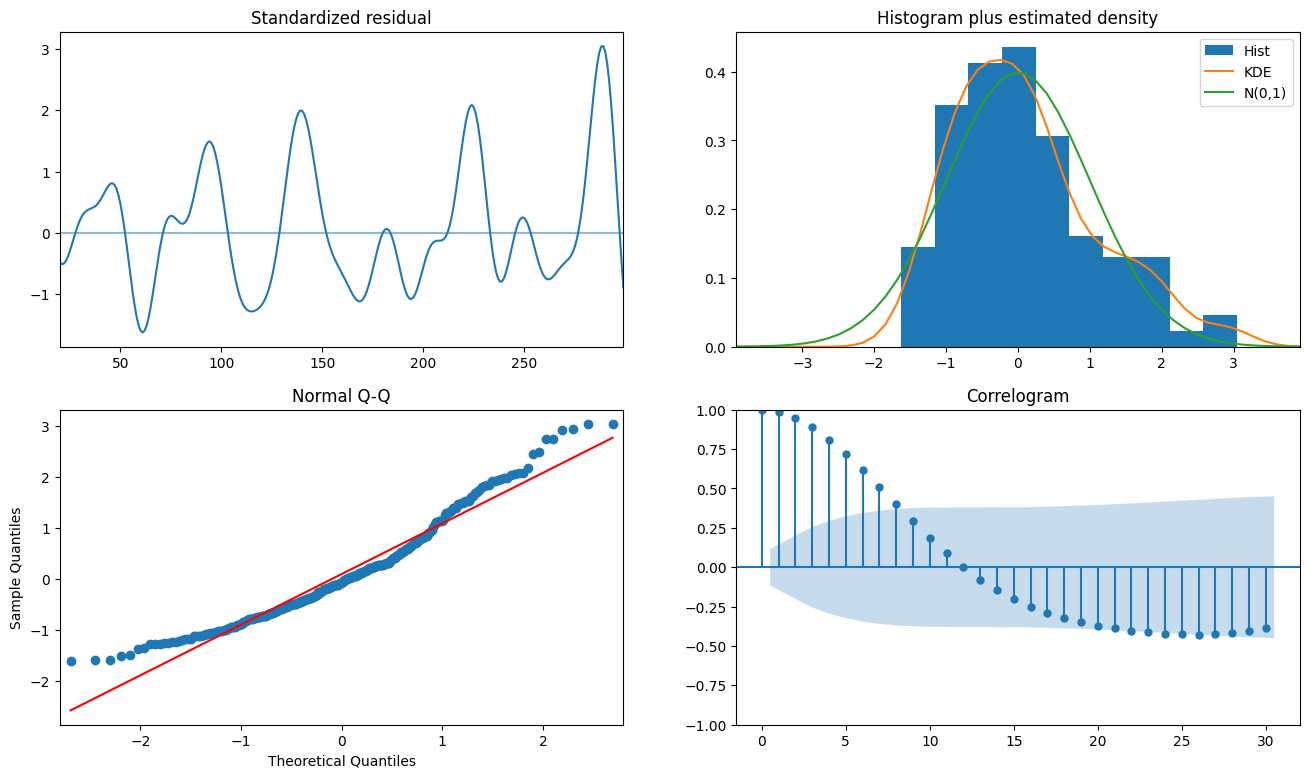

In [115]:
fig = plt.figure(figsize=(16, 9))
fig = res.plot_diagnostics(fig=fig, lags=30)

## ARMA Model

In [116]:
n_train = 300
arima_model = ARIMA(detrended_signal[:ntrain], order=(5, 0, 5))
res = arima_model.fit()
print(res.summary())

/home/aurelien.stumpf/Code/deep_env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/aurelien.stumpf/Code/deep_env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  300
Model:                 ARIMA(5, 0, 5)   Log Likelihood                 686.753
Date:                Thu, 16 May 2024   AIC                          -1349.506
Time:                        14:02:22   BIC                          -1305.061
Sample:                             0   HQIC                         -1331.719
                                - 300                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0604      0.003    -20.257      0.000      -0.066      -0.055
ar.L1         -0.8560      0.014    -62.180      0.000      -0.883      -0.829
ar.L2          1.8246      0.015    124.995      0.0

/home/aurelien.stumpf/Code/deep_env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


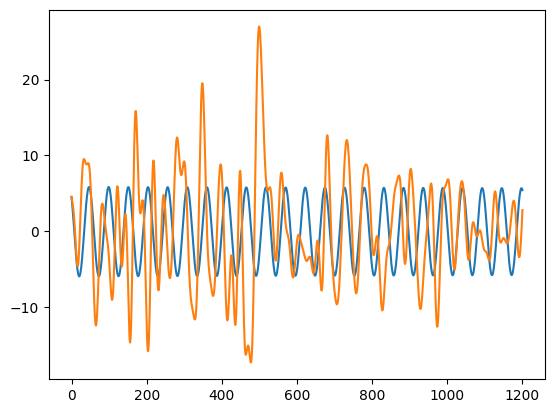

In [117]:
predicted_signal = res.predict(start=ntrain, end=ntrain+ntest-1)
plt.plot(predicted_signal)
plt.plot(detrended_signal[ntrain:])
plt.show()

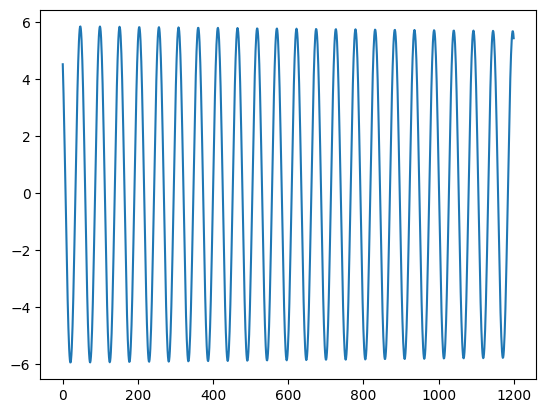

In [118]:
plt.plot(predicted_signal)